The preprocessing and feature engineering method I use here is inspired by [this notebook](https://www.kaggle.com/code/mtszkw/xgboost-for-stock-trend-prices-prediction)

In [21]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
import statsmodels.api as sm

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")


# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [22]:
df = pd.read_csv('10-Largest-Fast-Food-Companies-Stock/stocks/MCD.csv')

# I want to crop the time frame starting at 2010 to reduct the amount of data to be processed
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year >= 2010].copy()
df.index = range(len(df))

df.head()

Date       Open   High        Low      Close  Adj Close    Volume
0 2010-01-04  62.630001  63.07  62.310001  62.779999  41.753368   5839300
1 2010-01-05  62.660000  62.75  62.189999  62.299999  41.434120   7099000
2 2010-01-06  62.200001  62.41  61.060001  61.450001  40.868813  10551300
3 2010-01-07  61.250000  62.34  61.110001  61.900002  41.168106   7517700
4 2010-01-08  62.270000  62.41  61.599998  61.840000  41.128197   6107300

# Historical prices

OHLC (Open/High/Low/Close) chart as well as Volume chart to get a sense of the historical prices.

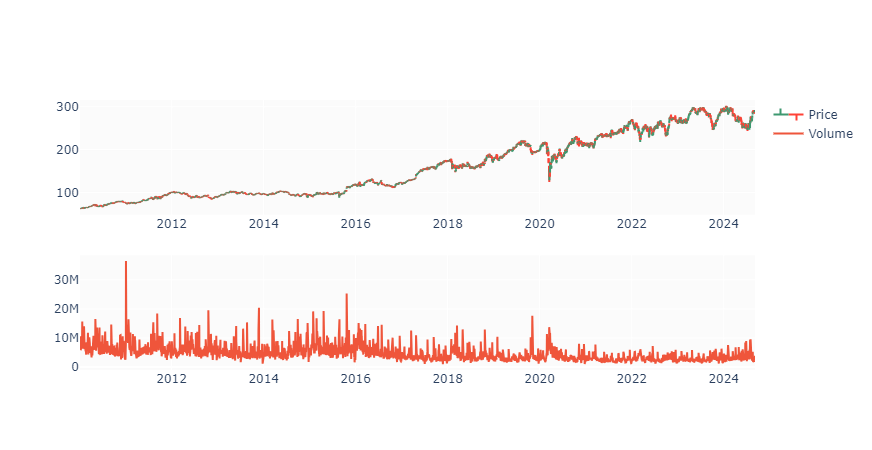

In [23]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

Decomposition

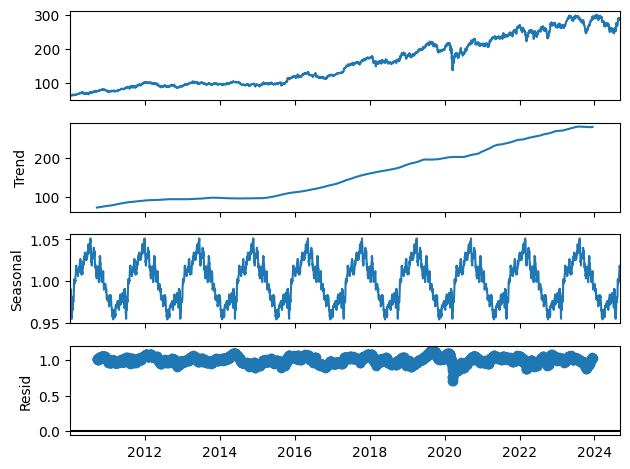

In [24]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
decomposition = sm.tsa.seasonal_decompose(df_close, model='multiplicative', period=365)
decomposition.plot();

# Technical indicators

I'm calculating few moving averages to be used as features, Simple Moving Average(SMA) and Exponential Moving Average (EMA), these averages are then shifted by one to prevent data leakage later on.

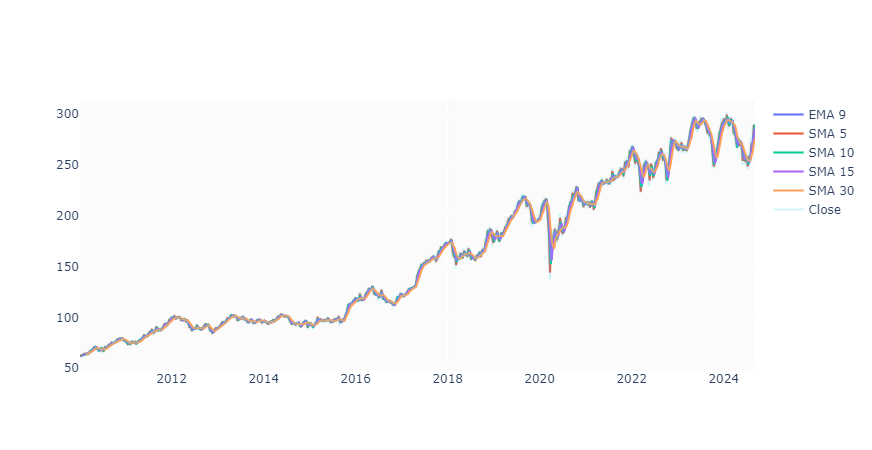

In [25]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

Adding RSI (Relative Strength Index) indicator to predict whether a stock is overbought/oversold.

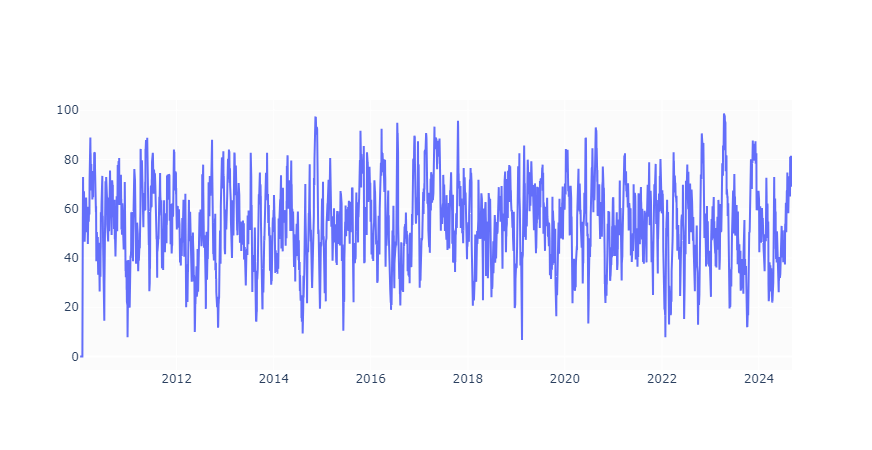

In [26]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

MACD (Moving Average Convergence Divergence)

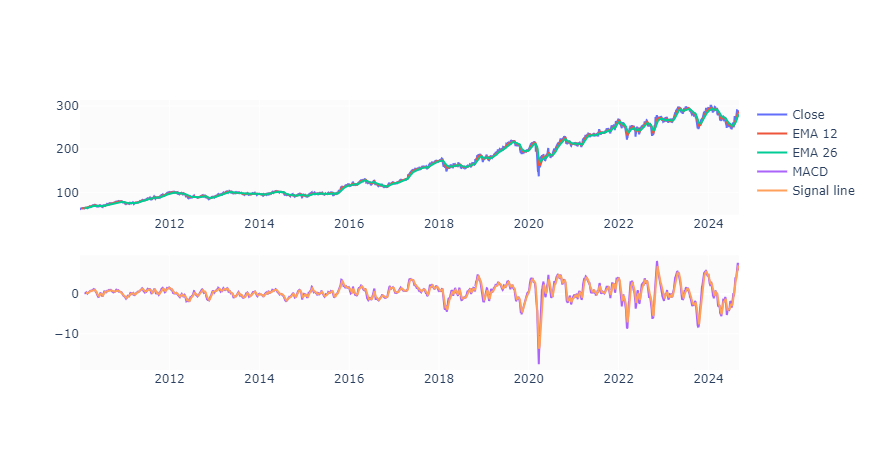

In [27]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

Adding Lag-1 feature

In [28]:
df['Close'] = df['Close'].shift(-1)

Dropping invalid columns (since we calculated moving averages and shifted columns)

In [29]:
print(f"Before: {df.shape}")
df = df.dropna()
df.index = range(len(df))
print(f"After: {df.shape}")

Before: (3694, 15)
After: (3660, 15)


# Model

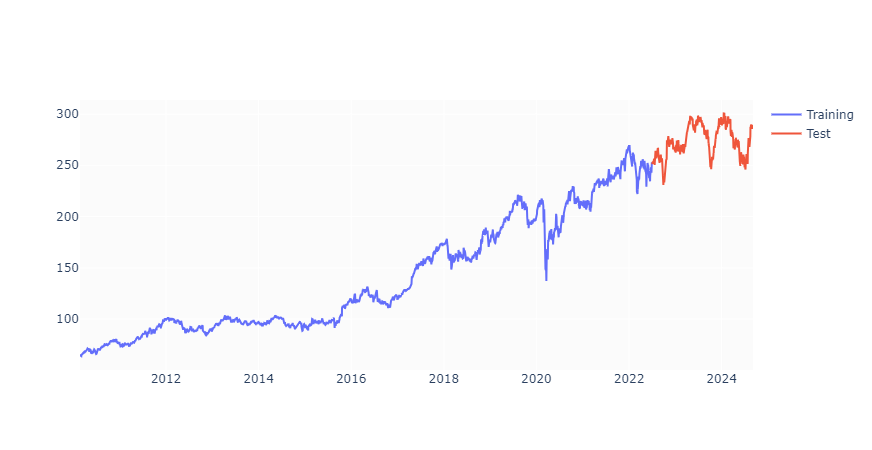

In [30]:
test_size  = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))

train_df  = df.loc[:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [31]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'Adj Close']

train_df = train_df.drop(drop_cols, axis = 1)
test_df  = test_df.drop(drop_cols, axis = 1)
train_df.head()

Close      EMA_9      SMA_5     SMA_10     SMA_15     SMA_30  \
0  64.870003  63.786897  64.216001  63.798000  63.840000  63.346000   
1  65.260002  63.888019  64.452000  63.938000  63.996000  63.441667   
2  64.379997  63.988739  64.624001  64.133001  64.061333  63.542667   
3  63.849998  64.118795  64.824001  64.302001  64.143333  63.640667   
4  63.980000  64.145456  64.803999  64.415001  64.088000  63.698000   

         RSI      MACD  MACD_signal  
0  56.769210  0.333169     0.246599  
1  56.501572  0.364936     0.273113  
2  50.440944  0.414911     0.304138  
3  52.962955  0.382768     0.321024  
4  54.580140  0.313023     0.319331

In [32]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], axis = 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], axis = 1)

X_test.head()

EMA_9       SMA_5      SMA_10      SMA_15      SMA_30        RSI  \
3112  243.760634  246.476001  242.818001  241.590000  242.905001  71.354190   
3113  244.680571  247.488004  244.595001  242.310001  243.635334  69.162505   
3114  245.441513  248.540002  246.386000  243.304000  244.411667  67.349755   
3115  246.043363  250.266003  247.573001  244.170000  244.996667  68.502924   
3116  246.733027  251.306003  248.561002  245.115334  245.494668  76.136710   

          MACD  MACD_signal  
3112  0.991932    -0.263215  
3113  1.461848     0.081798  
3114  1.747146     0.414868  
3115  2.068823     0.745659  
3116  2.321204     1.060768

In [33]:
from sklearn.linear_model import ElasticNet

# ElasticNet model
ENet = ElasticNet(
    alpha = 0.1,
    l1_ratio = 0.1,
    max_iter = 1000
)

ENet.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+04, tolerance: 9.823e+02



ElasticNet(alpha=0.1, l1_ratio=0.1)

In [34]:
y_pred = ENet.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [252.28999329 251.46000671 252.94000244 253.24000549 253.27999878]
y_pred = [248.43617334 249.83752271 250.61117814 251.58372362 252.83747808]


In [35]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

RMSE: 3.82


In [36]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"MAPE: {mape:.2f}")

MAPE: 1.09


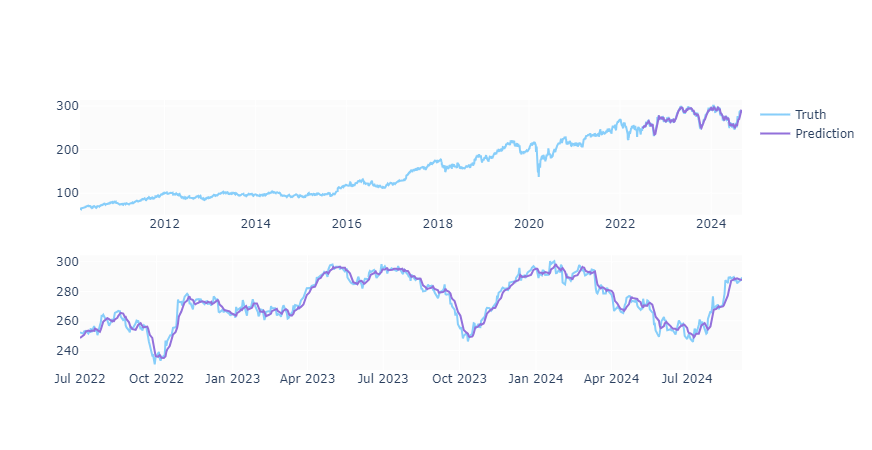

In [37]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()